In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def fix_okved(o: str) -> str:
    if o is None:
        return

    while o[-1] == '0' and '.' in o:
        if o[-2] == '.':
            o = o[:-2]
        else:
            o = o[:-1]
    return o

In [14]:
okved_data = pd.read_csv('../data/okved2/okved_2014_w_sections.csv', 
                         index_col=0, 
                         dtype={'code_okved': str})
sections = okved_data['section_id'].values

idx_to_okved = {0: 'root'}
idx_to_okved |= okved_data['native_code'].to_dict()
okved_to_idx = {v: k for k, v in idx_to_okved.items()}

embeddings_bert = np.load('../data/okved2/okved_embeddings.npy')
embeddings_model = np.load('../embeddings/embeddings_loss_1_42.npy')
embedding_simple = np.array([list(o) for o in okved_data['code_okved'].values]).astype(int)

okved_consumption = pd.read_csv('../data/stats/okved_consumption.csv')

In [19]:
prov_indices = okved_consumption['okved_provider'].map(fix_okved).map(okved_to_idx)
cons_indices = okved_consumption['okved_consumer'].map(fix_okved).map(okved_to_idx)

X_bert = np.column_stack((embeddings_bert[prov_indices], embeddings_bert[cons_indices]))
X_bert = StandardScaler().fit_transform(X_bert)
X_model = np.column_stack((embeddings_model[prov_indices], embeddings_model[cons_indices]))
X_model = StandardScaler().fit_transform(X_model)

X_simple = np.column_stack((embedding_simple[prov_indices], embedding_simple[cons_indices]))
# X_simple = StandardScaler().fit_transform(X_simple)

y = okved_consumption['normalized_consumption']

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

model = LinearRegression().fit(X_model, y )
score = model.score(X_model, y) 
print('Модель: ', score)

model = LinearRegression().fit(X_bert, y)
score = model.score(X_bert, y) 
print('Берт: ', score)

model = LinearRegression().fit(X_simple, y)
score = model.score(X_simple, y) 
print('Простой: ', score)

Модель:  0.11335818332893977
Берт:  0.09975118568076236
Простой:  0.02483243488742759


In [80]:
lrs

Six-digit code    0.0248
BERT              0.0998
GNN               0.1133
dtype: float64

Text(0, 0.5, '$R^2$')

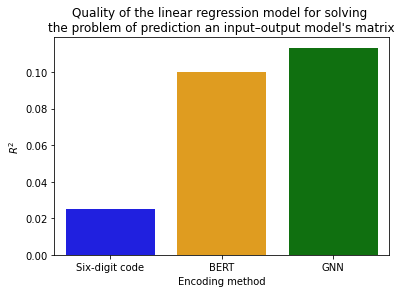

In [83]:
lrs = pd.Series([0.1133, 0.0998, 0.0248], index=['GNN', 'BERT', 'Six-digit code']).sort_values()
ax = sns.barplot(x=lrs.index, y=lrs.values, palette=['blue', 'orange', 'green'])
ax.set_title('Quality of the linear regression model for solving \nthe problem of prediction an input–output model\'s matrix')
ax.set_xlabel('Encoding method')
ax.set_ylabel('$R^2$')

In [ ]:
bert_scores = []
for i in range(100):
    model = MLPRegressor().fit(X_bert, y)
    score = model.score(X_bert, y) 
    bert_scores.append(score)

In [ ]:
model_scores = []
for i in range(100):
    model = MLPRegressor().fit(X_model, y)
    score = model.score(X_model, y) 
    model_scores.append(score)

In [29]:
simple_scores = []
for i in tqdm(range(100)):
    model = MLPRegressor().fit(X_simple, y)
    score = model.score(X_simple, y) 
    simple_scores.append(score)

100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


In [ ]:
# with open('scores.pickle', 'wb') as fp:
#     pickle.dump({"model_scores":model_scores, "bert_scores": bert_scores}, fp)

In [ ]:
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')

Модель: 0.33±0.28
Берт: 0.13±0.46


In [30]:
print(f'Простой: {np.mean(simple_scores):.2f}±{np.std(simple_scores):.2f}')

Простой: -0.37±0.13


In [35]:
with open('scores.pickle', 'rb') as fp:
    data = pickle.load(fp)
    model_scores = data['model_scores']
    bert_scores = data['bert_scores']

In [36]:
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')

Модель: 0.33±0.28
Берт: 0.13±0.46


In [70]:
print(f'Модель: {np.around(np.quantile(model_scores, q=[0.25, 0.5, 0.75]), decimals=2)}')
print(f'Берт: {np.around(np.quantile(bert_scores, q=[0.25, 0.5, 0.75]), decimals=2)}')
print(f'Простой: {np.around(np.quantile(simple_scores, q=[0.25, 0.5, 0.75]), decimals=2)}')

Модель: [0.23 0.39 0.52]
Берт: [-0.1   0.24  0.48]
Простой: [-0.46 -0.36 -0.27]


Text(0.5, 1.0, "Quality of the NN model for solving the problem of prediction an input–output model's matrix")

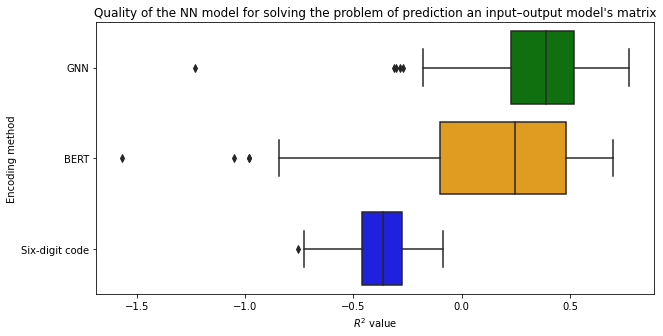

In [85]:
import seaborn as sns

df = pd.DataFrame({'GNN': model_scores, 
                   'BERT': bert_scores, 
                   'Six-digit code': simple_scores})
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(y='variable', x='value', data=df.melt(), ax=ax, orient='h', palette=['green', 'orange', 'blue'])
ax.set_xlabel('$R^2$ value')
ax.set_ylabel('Encoding method')
ax.set_title('Quality of the NN model for solving the problem of prediction an input–output model\'s matrix')

In [55]:
okved_consumption_cut = okved_consumption.query('okved_provider != okved_consumer')
okved_consumption_cut.loc[:, 'okved_provider'] = okved_consumption_cut['okved_provider'].map(fix_okved)
okved_consumption_cut.loc[:, 'okved_consumer'] = okved_consumption_cut['okved_consumer'].map(fix_okved)

prov_indices = okved_consumption_cut['okved_provider'].map(okved_to_idx)
cons_indices = okved_consumption_cut['okved_consumer'].map(okved_to_idx)
y = okved_consumption_cut['normalized_consumption']

C:\Users\Nikita\AppData\Local\Temp/ipykernel_6584/445187904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  okved_consumption_cut.loc[:, 'okved_provider'] = okved_consumption_cut['okved_provider'].map(fix_okved)
C:\Users\Nikita\AppData\Local\Temp/ipykernel_6584/445187904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  okved_consumption_cut.loc[:, 'okved_consumer'] = okved_consumption_cut['okved_consumer'].map(fix_okved)


In [56]:
from sklearn.metrics import pairwise_distances

In [57]:
def max_provider(group):
    return group.loc[group['normalized_consumption'].idxmax(), 'okved_provider']

def mrr(okved_consumption, embeddings):
    largest_provider = okved_consumption.groupby('okved_consumer').apply(max_provider)
    largest_provider_idx = largest_provider.map(okved_to_idx)
    
    all_providers = okved_consumption['okved_provider'].unique()
    all_providers_idx = np.array([okved_to_idx[o] for o in all_providers])
    all_providers_emb = embeddings[all_providers_idx]
    pwd = pairwise_distances(all_providers_emb)

    rs = []
    for idx, provider_code in enumerate(all_providers):
        if provider_code not in largest_provider_idx.index:
            print(f'Skipping {provider_code}...')
            continue
        sorted_idx = all_providers_idx[np.argsort(pwd[idx])]
        rank, = np.where(sorted_idx==largest_provider_idx[provider_code])
        rs.append(rank[0])
    rs = np.array(rs)
    return np.mean(1 / (rs + 1))

Quality of different encoding approaches for finding the closest industries

Skipping 94...
Skipping 97...
Skipping 94...
Skipping 97...
Skipping 94...
Skipping 97...


Text(0, 0.5, 'MRR')

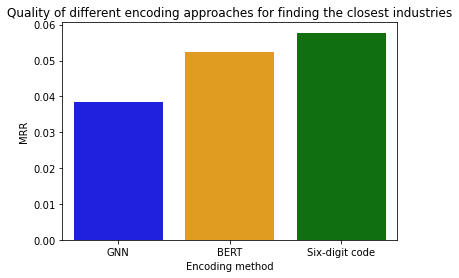

In [87]:
mrr_rgcn = mrr(okved_consumption_cut, embeddings_model)
mrr_bert = mrr(okved_consumption_cut, embeddings_bert)
mrr_simple = mrr(okved_consumption_cut, embedding_simple)
mrrs = pd.Series([mrr_bert, mrr_rgcn, mrr_simple], index=['BERT', 'GNN', 'Six-digit code']).sort_values()
ax = sns.barplot(x=mrrs.index, y=mrrs.values, palette=['blue', 'orange', 'green'])
ax.set_title('Quality of different encoding approaches for finding the closest industries')
ax.set_xlabel('Encoding method')
ax.set_ylabel('MRR')

In [71]:
mrr_simple

0.05775211626022114